# NeurIPS_Open-Polymer-Prediction-2025

### Goal 
Predicting polymer properties with machine learning to accelerate sustainable materials research.

### Data
In this competition, your task is to use polymer structure data (SMILES) to predict five key chemical properties derived from molecular dynamics simulation: glass transition temperature (Tg), fractional free volume (FFV), thermal conductivity (Tc), polymer density, and radius of gyration (Rg). Successfully predicting these properties is crucial for scientists to accelerate the design of novel polymers with targeted characteristics, which can be used in various applications.

In [1]:
#import
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs
from sklearn.manifold import TSNE
from rdkit.Chem import Descriptors, rdMolDescriptors

In [2]:
datafile = pd.read_csv("train.csv")

In [3]:
datafile.drop_duplicates().shape #no duplicate

(7973, 7)

In [4]:
datafile.isna().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

Dataset contains a lot of NaN making it very sparse for many properties

#### EDA

In [5]:
def box(property):
    print(f"Property: {property}")
    plt.figure(figsize=(8, 5))
    plt.boxplot(datafile[property].dropna())
    plt.xlabel("Molecule")
    plt.ylabel(property)
    plt.show()

In [6]:
property = ["Tg","Tc","FFV","Density","Rg"]

Property: Tg


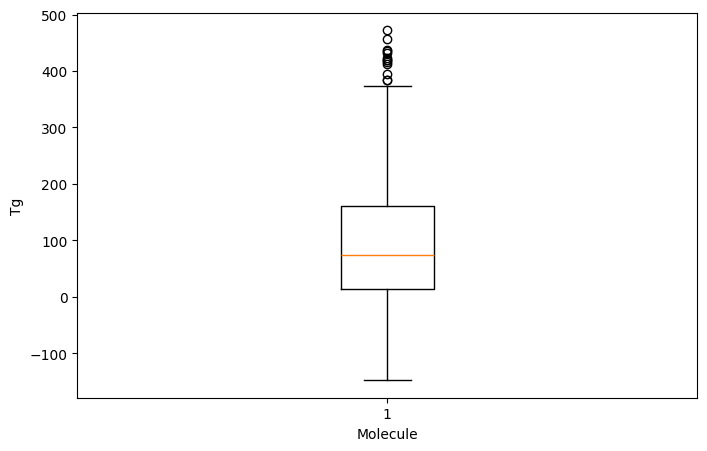

Property: Tc


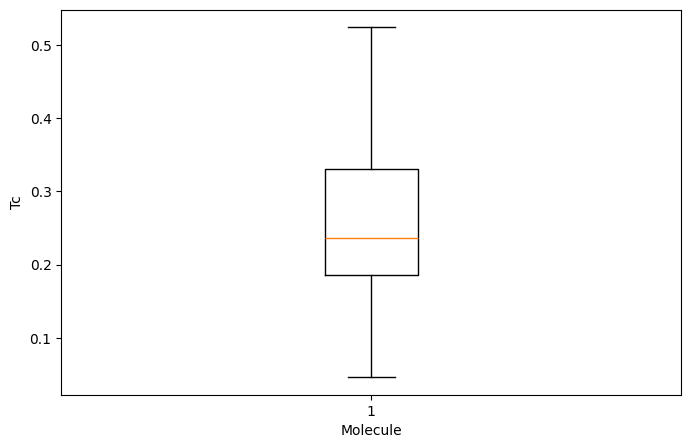

Property: FFV


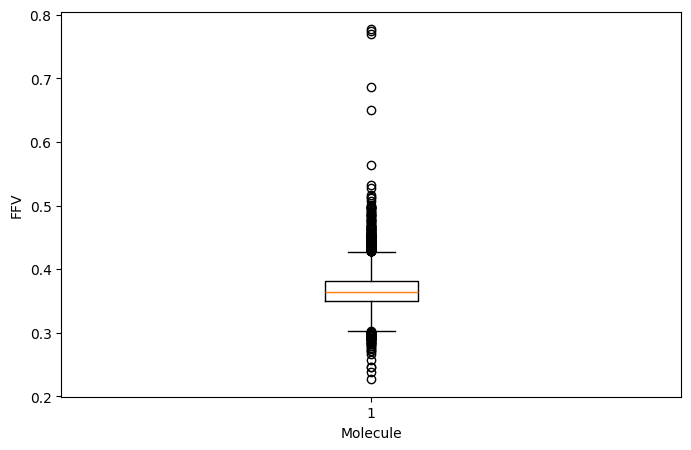

Property: Density


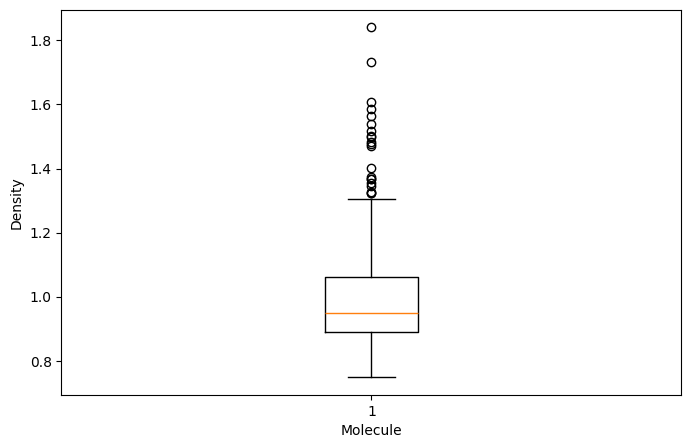

Property: Rg


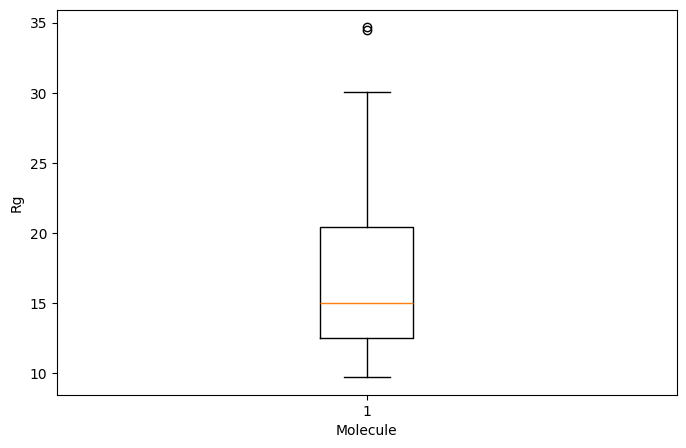

In [7]:
for i in property:
    box(i)

In [8]:
data=datafile.copy()

In [9]:
#Number of atoms
def get_num_nodes(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol else 0

In [10]:
def plot_smilesvsproperties(property):
    print(f"Property: {property}")
    datafile = data[['SMILES',property]]
    datafile.dropna(inplace=True)
    smiles_list = datafile["SMILES"].to_list()
    activity_values = datafile[property].to_list()
    datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]
    size = datafile["atoms"].to_list()

    plt.figure(figsize=(8, 5))
    sns.histplot(datafile["atoms"],  kde=True, color='g')
    plt.xlabel("Number of Atoms per Molecule")
    plt.ylabel("Count")
    plt.title("Distribution of molecule Sizes")
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.scatter(datafile[property],datafile.atoms)
    plt.xlabel(property)
    plt.ylabel("Number of Nodes/Atoms")
    plt.title(f"{property} vs Number of Atoms")
    plt.show()

Property: Tg


C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)
C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]


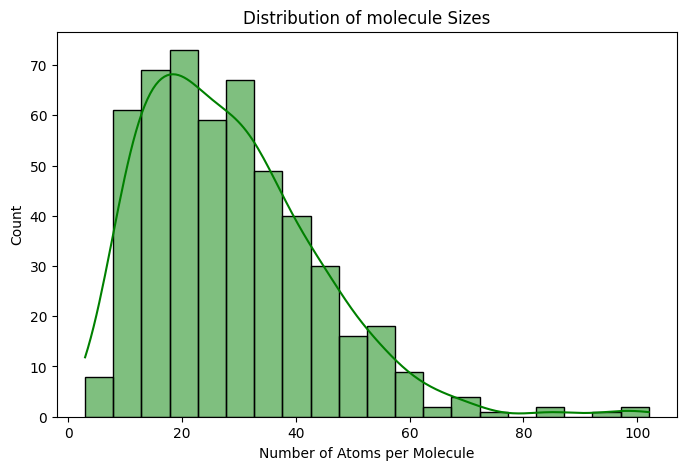

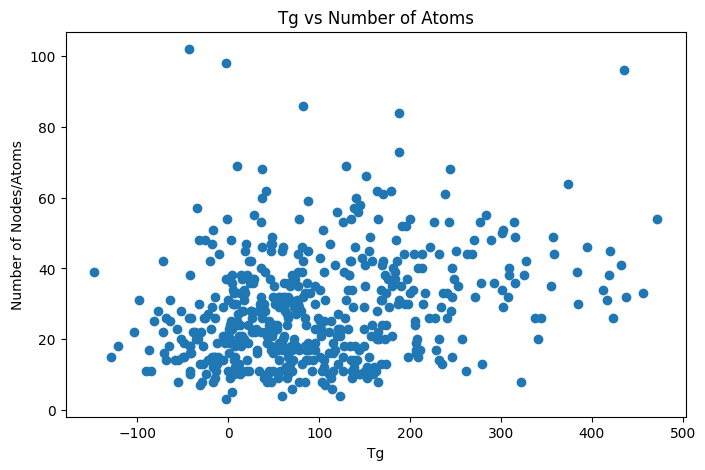

Property: Tc


C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)
C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]


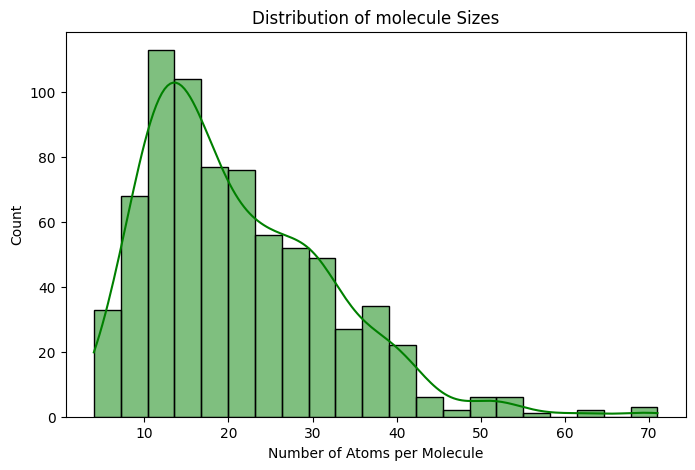

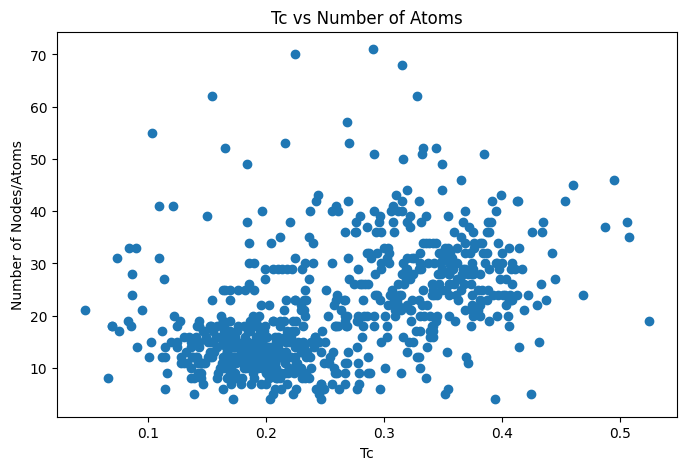

Property: FFV


C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)
C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]


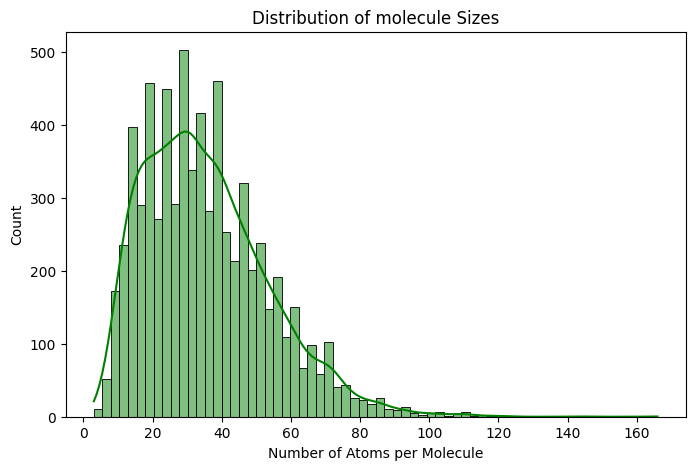

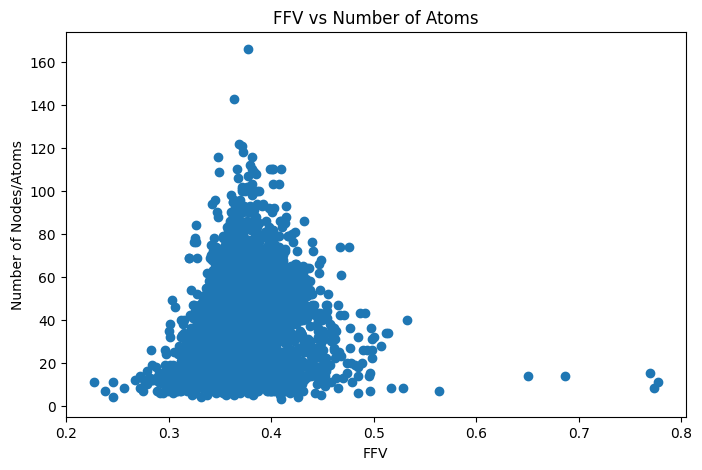

Property: Density


C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)
C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]


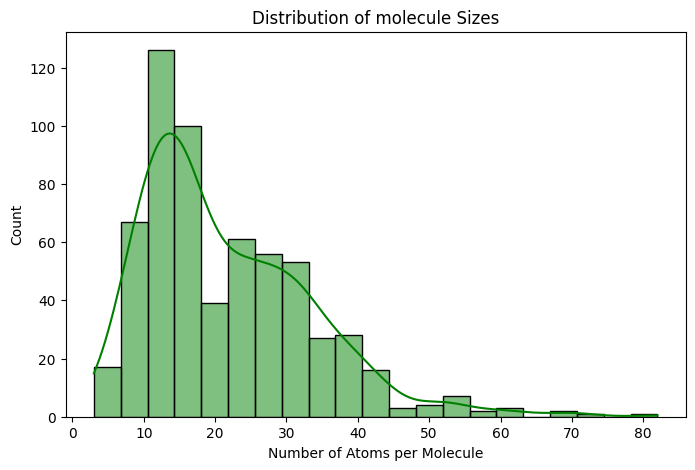

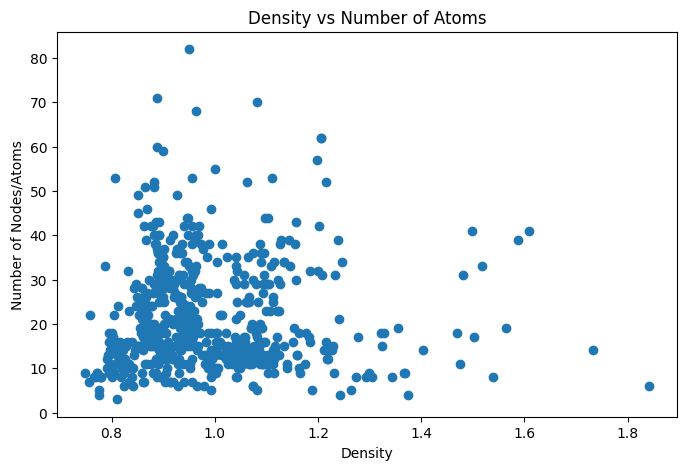

Property: Rg


C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)
C:\Users\shasa\AppData\Local\Temp\ipykernel_13080\4226719018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]


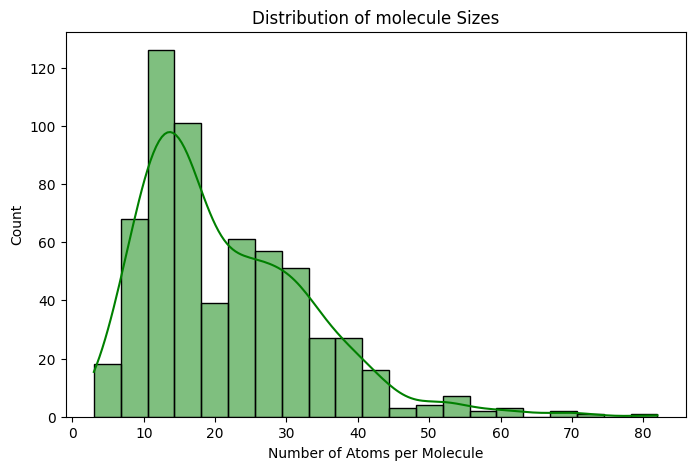

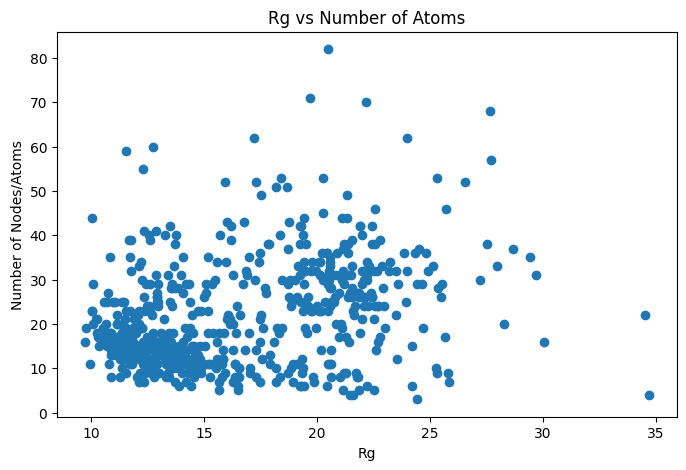

In [11]:
for i in property:
    plot_smilesvsproperties(i)

#### Chemical space

In [20]:
#Generating Morgan Fingerprint
def smiles_to_fingerprint(smiles, radius=3, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [23]:
smiles_list = datafile["SMILES"].to_list()

In [24]:
fingerprints = np.array([smiles_to_fingerprint(s) for s in smiles_list if smiles_to_fingerprint(s) is not None])

[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerator
[22:35:33] DEPRECATION WARNING: please use MorganGenerat

In [25]:
#tSNE

In [26]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50) #https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html
embedding = tsne.fit_transform(fingerprints)

In [27]:
df = pd.DataFrame(embedding, columns=["X", "Y"])

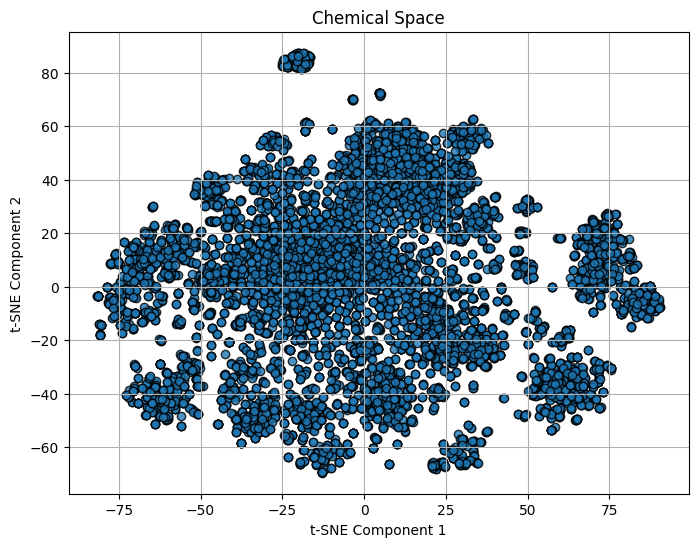

In [28]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], edgecolors='k', alpha=0.8)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

In [34]:
fingerprints = pd.DataFrame(fingerprints)
fingerprints["SMILES"] = smiles_list

In [35]:
def feature(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)  
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)  
    hba = Descriptors.NumHAcceptors(mol)  
    rotatable_bonds = Descriptors.NumRotatableBonds(mol) 
    f_sp3 = rdMolDescriptors.CalcFractionCSP3(mol) 
    num_rings = rdMolDescriptors.CalcNumRings(mol) 
    aromatic_rings = rdMolDescriptors.CalcNumAromaticRings(mol)
    formal_charge = Chem.GetFormalCharge(mol)
    return [smiles,logp,tpsa,hbd,hba,rotatable_bonds,f_sp3,num_rings,aromatic_rings,formal_charge]

In [36]:
list_dict=[]
for i in datafile["SMILES"]:
    list_dict.append(feature(i))

In [37]:
prop = pd.DataFrame(list_dict)

In [38]:
prop.columns = ["SMILES","logp","tpsa","hbd","hba","rotatable_bonds","f_sp3","num_rings","aromatic_rings","formal_charge"]

In [40]:
datafile = datafile.merge(prop,on="SMILES")
datafile = datafile.merge(fingerprints,on="SMILES")

In [42]:
data_prop = datafile[["logp","tpsa","hbd","hba","rotatable_bonds","f_sp3","num_rings","aromatic_rings","formal_charge"]]

In [43]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
embedding = tsne.fit_transform(data_prop)

In [44]:
df = pd.DataFrame(embedding, columns=["X", "Y"])

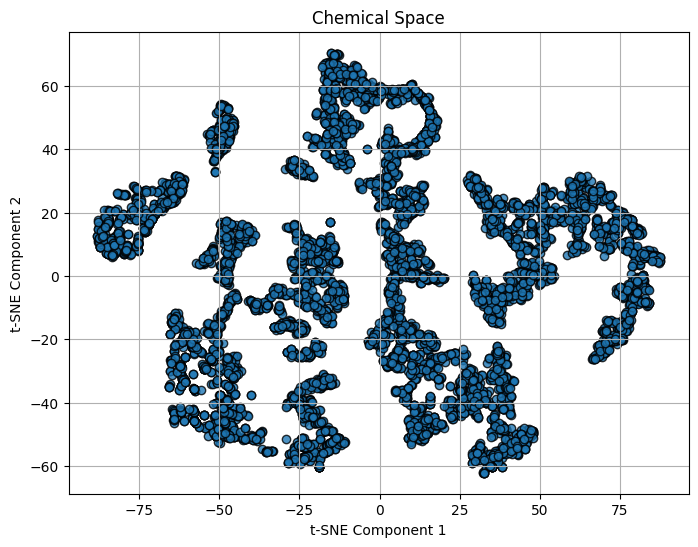

In [45]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"],edgecolors='k', alpha=0.8)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

The chemical space based on fingerprint and molecular discriptor suggest a better clustering/seperation with molecular discriptos.

In [48]:
datafile.to_csv("processed_train.csv",index=False)